<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/portfolio_crypto_ZH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U kaleido

The following program used to calculate asset and portfolio statistics was created by Steven Medvetz (https://github.com/StevenMedvetz/stock-analysis/tree/main). I use this program to generate plots of the closing prices as well as calculate the mean return and standard deviation from the mean for each stock in the portfolio, as well as the correlation and covariance matrices between the stocks in the portfolio. As this is a cryptocurrency portfolio notebook, all stock tickers are of cryptocurrencies. Data is taken from the Yahoo Finance website 'yfinance'.

In [2]:
import numpy as np
import yfinance as yf
from datetime import datetime
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import random
pio.renderers.default = "png"

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
class Asset:
    def __init__(self, ticker, start_date, end_date = datetime.today().strftime('%Y-%m-%d')):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date

    def get_data(self):
        df = yf.download(self.ticker, start = self.start_date, end = self.end_date)
        return df

    def simple_returns(self, adj = False, cum = False):
        df = self.get_data()
        if adj:
            simple_returns = df["Adj Close"].pct_change().dropna()
        else:
            simple_returns = df["Close"].pct_change().dropna()
        if cum:
            simple_returns = (1 + simple_returns).cumprod() - 1
        return simple_returns

    def log_returns(self, adj = False, cum = False):
        simple_returns = self.simple_returns(adj, cum)
        log_returns = np.log(1+simple_returns)
        return log_returns

    def std(self, adj = False, crypto = False):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        std = returns.describe().T.loc["std"]
        std = std*np.sqrt(trading_days)
        return std

    def mean_return(self, adj = False, crypto = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        mean = returns.describe().T.loc["mean"]
        mean = mean*trading_days # Multiply by number of trading days
        return mean

    def returns_plot(self, adj = False, cum = False, log = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj, cum).mul(100)
        if log:
            returns = self.log_returns(adj, cum).mul(100)
        try:
            returns = returns.to_frame()
        except:
            pass

        returns = returns.rename(columns={'Close': 'Returns'})
        fig = px.line(returns, template = template)
        fig.update_traces(hovertemplate='%{y:.2f}%')
        fig.update_layout(
            showlegend = True,
            legend = dict(title = None, font = dict(size = 16)),
            title={
                'y':0.95,
                'x':0.5,
                'text': f"{self.ticker} Daily Returns",
                'font': {'size': 24},

                'xanchor': 'center',
                'yanchor': 'top'},
            hovermode = "x unified",
            xaxis_title = "Date",
            yaxis_title = "% Returns")

        fig.show()
        return returns

    def close_plot(self, adj = False, normalize = False, template = 'plotly_dark'):
        df = self.get_data()

        if adj:
            df["CLose"] = df["Adj Close"]
            title = f"{self.ticker} Adjusted Closing Price"
        else:
            title = f"{self.ticker} Closing Price"

        if normalize:
            df["Close"] = df["Close"].div(df["Close"].iloc[0]) #Normalizes data
            fig = px.line(df["Close"],
                          x = df.index,
                          y = df["Close"],
                          title = "Normalized " + title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='Price: $%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Normalized " + title + " (USD)"
                )
            fig.show()
        else:

            fig = px.line(df["Close"],
                          x = df.index,
                          y = df["Close"],
                          title = title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='Price: $%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Closing Price (USD)"
                )
            fig.show()


    def candlestick(self, sma1 = 0, sma2 = 0, template = 'plotly_dark'):

        ticker = Asset(self.ticker, self.start_date)
        df = ticker.get_data()

        fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02, row_heights=[0.7, 0.3])
        fig.add_trace(go.Candlestick(x=df.index,
                                      open=df['Open'],
                                      high=df['High'],
                                      low=df['Low'],
                                      close=df['Close'],
                                      name='candlestick'),

                      row=1, col=1)
        fig.update_traces(increasing_line_width = 1.5,
                          decreasing_line_width = 1.5
                         )
        if sma1 > 0:
            fig.add_trace(go.Scatter(x=df.index, y=df['Close'].rolling(window=sma1).mean(),
                                      name=f'{sma1}-day moving average', line=dict(color='lightblue', width = 1)),
                          row=1, col=1)
        if sma2 > 0:
            fig.add_trace(go.Scatter(x=df.index, y=df['Close'].rolling(window=sma2).mean(),
                                      name=f'{sma2}-day moving average', line=dict(color='red', width = 1)),
                          row=1, col=1)

        fig.add_trace(go.Bar(x=df.index,
                             y=df['Volume'],
                             name='volume'),
                      row=2, col=1)

        fig.update_layout(
                          title={
                          'text': f'{self.ticker} Candlestick Chart with Volume',
                          'y':0.9,
                          'x':0.5,
                          'font': {'size': 24},
                          'xanchor': 'center',
                          'yanchor': 'top',},
                          xaxis_rangeslider_visible=False,
                          xaxis_title='Date',
                          yaxis_title='Price (USD)',
                          hovermode = "x unified",
                          bargap=0,
                          bargroupgap=0,
                          template = template)
        fig.update_xaxes(title_text='', row=1, col=1, showgrid=False)
        fig.update_xaxes(title='Date', row=2, col=1)
        fig.update_yaxes(title='Volume',row=2,col=1)

        fig.show()

In [4]:
class Portfolio:
    def __init__(self, assets, start_date, weights = None, end_date = datetime.today().strftime('%Y-%m-%d')):
        self.assets = assets
        self.start_date = start_date
        self.end_date = end_date

        if weights is not None:
            self.weights = np.array(weights)
        else:
            self.weights = self.generate_random_weights()
    def generate_random_weights(self):
    # Generate random weights that add up to 1 and round to 1 digit
        weights = [round(random.random(), 1) for _ in range(len(self.assets))]
        total_weight = sum(weights)
        weights = np.array([round(weight / total_weight, 1) for weight in weights])
        print(weights)
        return weights



    # Data gather using yfinance
    def get_data(self):
        df = yf.download(self.assets, start = self.start_date, end = self.end_date)
        return df

    # Plot the closing price data
    def close_plot(self, adj = False, normalize = False, template = 'plotly_dark'):
        df = self.get_data()
        if adj:
            close = df.loc[:,"Adj Close"].copy()
            title = "Adjusted Closing Prices"
        else:
            close = df.loc[:,"Close"].copy()
            title = "Closing Prices"

        if normalize:
            normclose = close.div(close.iloc[0]) #Normalizes data

            normclose = normclose.to_frame()
            fig = px.line(normclose,
                          x = normclose.index,
                          y = normclose.columns,
                          title = "Normalized " + title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "Normalized " + title + " (USD)"
                )
            fig.show()
        else:


            fig = px.line(close,
                          x = close.index,
                          y = close.columns,
                          title = title,
                          template = template) # Plotting Normalized closing data
            fig.update_traces(hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                'y':0.9,
                'x':0.5,
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = title +  " (USD)"
                )
            fig.show()


    def simple_returns(self, adj = False, cum = False):
        df = self.get_data()
        if adj:
            simple_returns = df["Adj Close"].pct_change().dropna()
        else:
            simple_returns = df["Close"].pct_change().dropna()
        if cum:
            simple_returns = (1 + simple_returns).cumprod() - 1
        return simple_returns

    def log_returns(self, adj = False, cum = False):
        simple_returns = self.simple_returns(adj, cum)
        log_returns = np.log(1+simple_returns)
        return log_returns


    def portfolio_returns(self, adj = False, cum = False):
        returns = self.simple_returns(adj, cum)
        portfolio_returns = (returns*self.weights).sum(axis=1)
        return portfolio_returns

    def returns_plot(self, port = False, benchmark = False, adj = False, cum = False, log = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj, cum).mul(100)
        if log:
            returns = self.log_returns(adj, cum).mul(100)
        fig = px.line(returns, template = template)
        fig.update_traces(hovertemplate='%{y}')
        fig.update_layout(
            legend = dict(title = None, font = dict(size = 16)),
            title={
                'y':0.95,
                'x':0.5,
                'text': "Asset Returns",
                'font': {'size': 24},
                'xanchor': 'center',
                'yanchor': 'top'},
            hovermode = "x unified",
            xaxis_title = "Date",
            yaxis_title = "% Returns")

        if port:
            portfolio_returns = self.portfolio_returns(adj, cum)
            fig = px.line(portfolio_returns, template = template)
            fig.update_traces(name = 'Returns',hovertemplate='%{y}')
            fig.update_layout(
                legend = dict(title = None, font = dict(size = 16)),
                title={
                    'y':0.95,
                    'x':0.5,
                    'text': "Portfolio Returns",
                    'font': {'size': 24},
                    'xanchor': 'center',
                    'yanchor': 'top'},
                hovermode = "x unified",
                xaxis_title = "Date",
                yaxis_title = "% Returns")

        fig.show()

    def cov_matrix(self, plot = False, cum = False, template = 'plotly_dark'):
        returns = self.simple_returns()
        if cum:
            returns = self.simple_returns(cum)
        cov_matrix = returns.cov()

        if plot:
            fig = px.imshow(cov_matrix, text_auto=True, color_continuous_scale='tempo', template = template, title = "Covariance Matrix")
            fig.update_layout(
                legend = dict(title = None),
                title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
                )
            fig.show()
        return cov_matrix

    def corr_matrix(self, plot = False, cum = False, template = 'plotly_dark'):
        returns = self.simple_returns()
        if cum:
            returns = self.simple_returns(cum)
        corr_matrix = returns.corr()
        if plot:
            fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='tempo', template = template, title = "Correlation Matrix")
            fig.update_layout(
                legend = dict(title = None),
                title={
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
                )
            fig.show()
        return corr_matrix

        #Standard Deviation of Portfolio w/ Optional Crypto Arg
    def port_std(self, crypto = False):
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252

        cov_matrix = self.cov_matrix()
        port_variance = np.dot(self.weights.T, np.dot(cov_matrix, self.weights))
        port_std = np.sqrt(port_variance) * np.sqrt(trading_days)


        return port_std

    def risk_return(self, adj = False, crypto = False, template = 'plotly_dark'):
        returns = self.simple_returns(adj).mul(100)
        if crypto:
            trading_days = 365
        else:
            trading_days  = 252
        summary = returns.describe().T.loc[:,["mean","std"]]
        summary["mean"] = round(summary["mean"]*trading_days,2) # Multiply by number of trading days
        summary["std"]  = round(summary["std"]*np.sqrt(trading_days),2)
        summary.rename(columns = {'mean':'% Return', 'std':'Risk'}, inplace = True)
        fig = px.scatter(summary,
                         x = 'Risk',
                         y = '% Return',
                         title = "Annual Risk / Return",
                         text = summary.index,
                         template = template)
        fig.update_traces(hovertemplate='Risk: %{x}<br>Return: %{y}')
        fig.update_traces(marker={'size': 15},
                          textposition='top center',
                          hoverlabel=dict(font=dict(size=15) ))
        fig.update_layout(
            legend = dict(title = None),
            title={
            'y':0.9,
            'x':0.5,
            'font': {'size': 24},
            'xanchor': 'center',
            'yanchor': 'top',},
            xaxis = dict(title = dict(font = dict(size = 20))),
            yaxis = dict(title = dict(font = dict(size = 20)))
            )
        fig.show()

    def pie_plot(self, template = 'plotly_dark'):
        data = pd.DataFrame({"Assets": self.assets,
                             "Weights": self.weights})
        fig=go.Figure(go.Pie(labels=data['Assets'],
                                 values=data['Weights'],
                                 name = "",
                                 textinfo = 'label + percent'))
        fig.update_layout(template = template)
        fig.update_traces(hovertemplate='%{label}: %{percent}')
        fig.show()

In [5]:
tickers = ['DAI-USD', 'USDT-USD', 'BNB-USD', 'SOL-USD', 'BTC-USD', 'ETH-USD', 'DOT-USD', 'ADA-USD', 'DOGE-USD', 'XRP-USD']
weights = [0.1 for i in range(len(tickers))]
start_date = '2024-01-10'
pf = Portfolio(tickers, start_date, weights)

[*********************100%%**********************]  10 of 10 completed


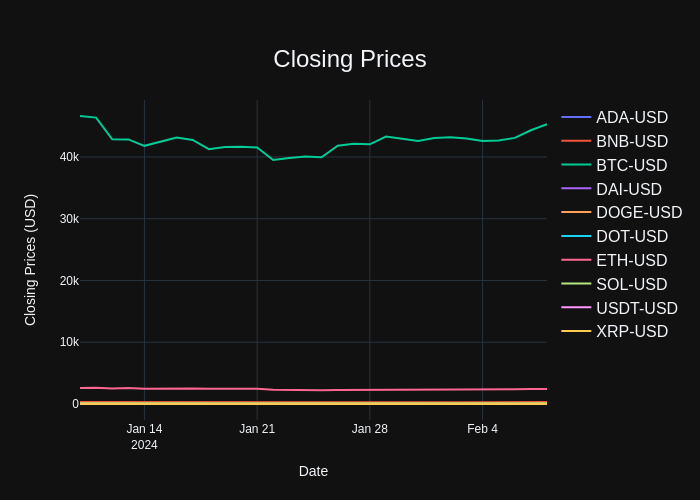

In [6]:
pf.close_plot()

In [7]:
pf.corr_matrix()

[*********************100%%**********************]  10 of 10 completed


Ticker,ADA-USD,BNB-USD,BTC-USD,DAI-USD,DOGE-USD,DOT-USD,ETH-USD,SOL-USD,USDT-USD,XRP-USD
Ticker,,,,,,,,,,
ADA-USD,1.000000,0.570300,0.820436,0.122935,0.637716,0.838383,0.701829,0.727624,0.405876,0.752988
BNB-USD,0.570300,1.000000,0.639343,0.074095,0.483648,0.616015,0.627439,0.402925,0.395957,0.520612
BTC-USD,0.820436,0.639343,1.000000,0.085484,0.571652,0.867603,0.751004,0.820868,0.441143,0.761786
DAI-USD,0.122935,0.074095,0.085484,1.000000,-0.085174,0.168308,0.211367,-0.002179,0.405588,-0.157641
DOGE-USD,0.637716,0.483648,0.571652,-0.085174,1.000000,0.593283,0.509820,0.479793,0.254991,0.683692
DOT-USD,0.838383,0.616015,0.867603,0.168308,0.593283,1.000000,0.741328,0.786792,0.412882,0.772325
ETH-USD,0.701829,0.627439,0.751004,0.211367,0.509820,0.741328,1.000000,0.667487,0.460077,0.549936
SOL-USD,0.727624,0.402925,0.820868,-0.002179,0.479793,0.786792,0.667487,1.000000,0.275424,0.668537
USDT-USD,0.405876,0.395957,0.441143,0.405588,0.254991,0.412882,0.460077,0.275424,1.000000,0.229318


In [8]:
pf.cov_matrix()

[*********************100%%**********************]  10 of 10 completed


Ticker,ADA-USD,BNB-USD,BTC-USD,DAI-USD,DOGE-USD,DOT-USD,ETH-USD,SOL-USD,USDT-USD,XRP-USD
Ticker,,,,,,,,,,
ADA-USD,9.309290e-04,3.837443e-04,5.937528e-04,6.263690e-07,6.085120e-04,7.247442e-04,4.794309e-04,8.696378e-04,4.839613e-06,4.591107e-04
BNB-USD,3.837443e-04,4.863633e-04,3.344392e-04,2.728766e-07,3.335748e-04,3.849066e-04,3.098049e-04,3.480794e-04,3.412616e-06,2.294382e-04
BTC-USD,5.937528e-04,3.344392e-04,5.626078e-04,3.385992e-07,4.240517e-04,5.830529e-04,3.988242e-04,7.626922e-04,4.089236e-06,3.610826e-04
DAI-USD,6.263690e-07,2.728766e-07,3.385992e-07,2.788637e-08,-4.448229e-07,7.963143e-07,7.902608e-07,-1.425460e-08,2.646919e-08,-5.260623e-07
DOGE-USD,6.085120e-04,3.335748e-04,4.240517e-04,-4.448229e-07,9.780650e-04,5.256895e-04,3.569743e-04,5.877751e-04,3.116509e-06,4.272823e-04
DOT-USD,7.247442e-04,3.849066e-04,5.830529e-04,7.963143e-07,5.256895e-04,8.027267e-04,4.702517e-04,8.732073e-04,4.571612e-06,4.372751e-04
ETH-USD,4.794309e-04,3.098049e-04,3.988242e-04,7.902608e-07,3.569743e-04,4.702517e-04,5.012712e-04,5.854000e-04,4.025562e-06,2.460478e-04
SOL-USD,8.696378e-04,3.480794e-04,7.626922e-04,-1.425460e-08,5.877751e-04,8.732073e-04,5.854000e-04,1.534428e-03,4.216326e-06,5.233230e-04
USDT-USD,4.839613e-06,3.412616e-06,4.089236e-06,2.646919e-08,3.116509e-06,4.571612e-06,4.025562e-06,4.216326e-06,1.527281e-07,1.790892e-06


In [9]:
asset_dict = {}
mret_dict = {}
sd_dict = {}
for tf in tickers:
  asset_dict[f'{tf}'] = Asset(tf, start_date)
  mret_dict[f'{tf}'] = asset_dict[f'{tf}'].mean_return()
  sd_dict[f'{tf}'] = asset_dict[f'{tf}'].std()
mret_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

{'DAI-USD': 0.055085441709406144,
 'USDT-USD': -0.023308905158789344,
 'BNB-USD': 44.27911638517982,
 'SOL-USD': 25.309384087011182,
 'BTC-USD': -18.086278573281064,
 'ETH-USD': -50.144325336997056,
 'DOT-USD': -100.85370970840557,
 'ADA-USD': -47.92069444115038,
 'DOGE-USD': -21.211880806088033,
 'XRP-USD': -128.25450468206944}

In [10]:
sd_dict

{'DAI-USD': 0.26509178074306466,
 'USDT-USD': 0.6203828106399865,
 'BNB-USD': 35.00907874294537,
 'SOL-USD': 62.183273501937165,
 'BTC-USD': 37.65330898467603,
 'ETH-USD': 35.54157434454221,
 'DOT-USD': 44.97634122688392,
 'ADA-USD': 48.43491681910439,
 'DOGE-USD': 49.6459837378426,
 'XRP-USD': 31.72276984013067}

In [11]:
#Narrow down stock selection to top 3 stocks with highest mean returns during
#this period (the assumption is that the portfolio was created on 2024-01-10)
x=list(mret_dict.values())
top3 = []
x.sort(reverse=True)
x=x[:3]
for i in x:
    for j in mret_dict.keys():
        if(mret_dict[j]==i):
            print(str(j)+" : "+str(mret_dict[j]))
            top3.append(j)

BNB-USD : 44.27911638517982
SOL-USD : 25.309384087011182
DAI-USD : 0.055085441709406144


In [12]:
#Now redo portfolio to only include top 3 cryptocurrency shares
weights = [e/max(x) for e in range(len(x))]
start_date = '2024-01-10'
pf = Portfolio(top3, start_date, weights)

[*********************100%%**********************]  3 of 3 completed


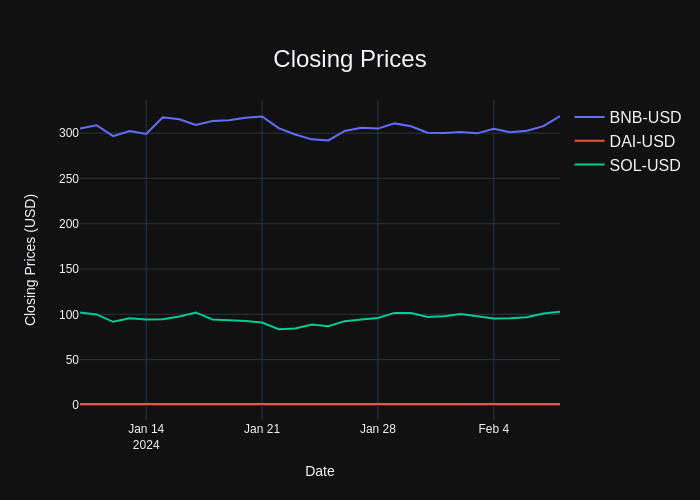

In [13]:
pf.close_plot()

In [14]:
pf.corr_matrix()

[*********************100%%**********************]  3 of 3 completed


Ticker,BNB-USD,DAI-USD,SOL-USD
Ticker,,,
BNB-USD,1.000000,0.074095,0.402925
DAI-USD,0.074095,1.000000,-0.002179
SOL-USD,0.402925,-0.002179,1.000000


In [15]:
pf.cov_matrix()

[*********************100%%**********************]  3 of 3 completed


Ticker,BNB-USD,DAI-USD,SOL-USD
Ticker,,,
BNB-USD,4.863633e-04,2.728766e-07,3.480794e-04
DAI-USD,2.728766e-07,2.788637e-08,-1.425460e-08
SOL-USD,3.480794e-04,-1.425460e-08,1.534428e-03


In [16]:
sdev_pf = pf.port_std()
sdev_pf

[*********************100%%**********************]  3 of 3 completed


0.02808688655281956

In [17]:
returns = pf.portfolio_returns()
returns

[*********************100%%**********************]  3 of 3 completed


Date
2024-01-11   -0.000941
2024-01-12   -0.003697
2024-01-13    0.001971
2024-01-14   -0.000759
2024-01-15    0.000177
2024-01-16    0.001500
2024-01-17    0.002050
2024-01-18   -0.003458
2024-01-19   -0.000410
2024-01-20   -0.000397
2024-01-21   -0.000839
2024-01-22   -0.003598
2024-01-23    0.000358
2024-01-24    0.002392
2024-01-25   -0.000934
2024-01-26    0.002883
2024-01-27    0.000839
2024-01-28    0.000851
2024-01-29    0.002650
2024-01-30   -0.000042
2024-01-31   -0.001985
2024-02-01    0.000389
2024-02-02    0.001194
2024-02-03   -0.001151
2024-02-04   -0.001111
2024-02-05    0.000033
2024-02-06    0.000625
2024-02-07    0.001917
2024-02-08    0.000809
dtype: float64

In [18]:
total_return_portfolio = sum(returns)
total_return_portfolio

0.001316989898690687

In [19]:
asset_dict = {}
mret_dict = {}
sd_dict = {}
for tf in top3:
  asset_dict[f'{tf}'] = Asset(tf, start_date)
  mret_dict[f'{tf}'] = asset_dict[f'{tf}'].mean_return()
  sd_dict[f'{tf}'] = asset_dict[f'{tf}'].std()
mret_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'BNB-USD': 44.27911638517982,
 'SOL-USD': 25.309384087011182,
 'DAI-USD': 0.055085441709406144}

In [20]:
sd_dict

{'BNB-USD': 35.00907874294537,
 'SOL-USD': 62.183273501937165,
 'DAI-USD': 0.26509178074306466}

In [21]:
#Calculate Fisher-Pearson sample skewness coefficient and kurtosis for each
#stock's returns
return_dict = {}
sum_ctr = 0
kurt_ctr = 0
skew_dict, kurt_dict = {}, {}
for tf in top3:
  mean = 0
  return_dict[f'{tf}'] = asset_dict[f'{tf}'].simple_returns()
  mean = sum(return_dict[f'{tf}'])/len(return_dict[f'{tf}'])
  for j in range(len(return_dict[f'{tf}'])):
    sum_ctr += (return_dict[f'{tf}'][j] - mean)**3
    kurt_ctr += (return_dict[f'{tf}'][j] - mean)**4
  skew_dict[f'{tf}'] = np.sqrt(len(return_dict[f'{tf}'])*(len(return_dict[f'{tf}']) - 1))/((len(return_dict[f'{tf}']) - 2)) *(sum_ctr/(len(return_dict[f'{tf}'])*(sd_dict[f'{tf}']**3)))
  kurt_dict[f'{tf}'] = kurt_ctr/(len(return_dict[f'{tf}'])*(sd_dict[f'{tf}']**4))
skew_dict

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'BNB-USD': 1.0155455020927939e-10,
 'SOL-USD': -1.081890682170484e-10,
 'DAI-USD': -0.0013964176055724221}

In [22]:
kurt_dict

{'BNB-USD': 5.361418147655964e-13,
 'SOL-USD': 4.626649957660452e-13,
 'DAI-USD': 0.0014007993005338449}

In [23]:
#Calculate entire portfolio return skewness and kurtosis
sum_returns = 0
sum_ctr, kurt_ctr = 0, 0
for tf in top3:
  sum_returns += return_dict[f'{tf}']
mean = sum(sum_returns)/len(sum_returns)
for j in range(len(sum_returns)):
  sum_ctr += (sum_returns[j] - mean)**3
  kurt_ctr += (sum_returns[j] - mean)**4
skew = np.sqrt(len(sum_returns)*(len(sum_returns) - 1))/((len(sum_returns) - 2)) * (sum_ctr/(len(sum_returns)*(sdev_pf**3)))
kurt = sum_ctr/(len(sum_returns)*(sdev_pf**4))

In [24]:
kurt

-126.26278379253525

In [25]:
skew

-3.742770612261803